In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Backtesting and Momentum_Trading


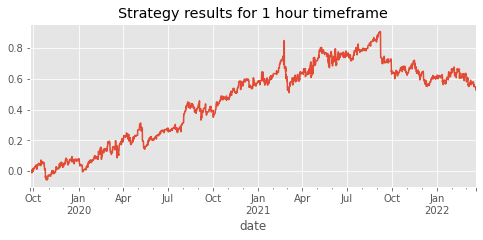

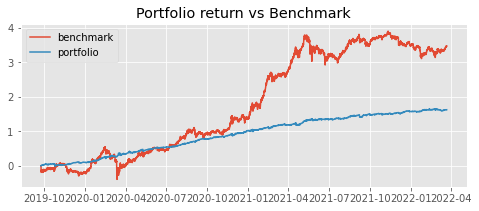

In [ ]:
# define a class for Backtesting 
class BackTest:
    '''
    function:
        open long: find our long position using open price
        open short: find our short position using open price
        reset_variablesL: reset all the variable to None 
        add_zeros: add 0 to store list for return, holding, and direction 
        close_position: calculate our close position and store the data
        check_barrier: check hit which barrier
        add_trade_cols: add data to the main dataframe
        run_backtest: run the backtest

    '''
    def __init__(self, csv_path, date_col, max_holding):
        # read the data 
        self.data = pd.read_csv(csv_path, parse_dates=[date_col],index_col=date_col,header=0)
        #calculate change in price
        self.data['t_plus'] = self.data.open.shift(-1)
        self.data['t'] = self.data.close.shift(-1)
        self.data['bench'] = (self.data.t/self.data.close)-1
        # drop
        self.data.dropna(inplace=True)
        #copy the data
        self.df = self.data.copy()
        # set trade variables 
        self.open_pos = False
        self.entry_price = None
        self.direction = None
        self.target_price = None
        self.stop_price = None
        # vertical barrier variable
        self.max_holding = max_holding
        self.max_holding_limit = max_holding

        self.cost = 0

     

        # special case of vertical barrier
        self.end_date = self.df.index.values[-1]

        self.store_return = []
        self.store_holding = []
        self.store_direction = []
        self.store_cost = []
        self.store_avg = []

    def open_long(self, price):
        '''

        :param price: price we open long at
        :return: populates trade variables from constructor with relevant variables
        '''
        self.open_pos = True
        # direction 0 , 1 , -1 for hold long short
        self.direction = 1
        self.entry_price = price
        self.target_price = price * self.ub_bound
        self.stop_price = price * self.lb_bound
        self.add_zeros()

    def open_short(self, price):
        '''

        :param price: price we open short at
        :return: populates trade variables from constructor with relevant variables
        '''
        self.open_pos = True
        self.direction = -1
        self.entry_price = price
        self.target_price = price * self.lb_bound
        self.stop_price = price * self.ub_bound
        self.add_zeros()

    def reset_variables(self):
        '''
        resets the variables after we close a trade
        '''
        self.open_pos = False
        self.entry_price = None
        self.direction = None
        self.target_price = None
        self.stop_price = None
        self.max_holding = self.max_holding_limit

    def add_zeros(self):
        self.store_return.append(0)
        self.store_holding.append(0)
        self.store_direction.append(0)


    def close_position(self, price):
        '''

        :param price: price we are exiting trade at
        :return: appends the trade pnl to the returns series
        and resets variables
        '''
        pnl = (price / self.entry_price - 1) * self.direction-self.fee
        self.cost+=self.entry_price
        self.store_return.append(pnl)
        self.store_direction.append(self.direction)
        holding = self.max_holding_limit - self.max_holding
        self.store_holding.append(holding)
        self.reset_variables()


    def check_barrier(self, price, time):
        # check upper horizontal barrier for long positions
        if price >= self.target_price and self.direction == 1:
            self.close_position(price)
        # check lower horizontal barrier for long positions
        elif price <= self.stop_price and self.direction == 1:
            self.close_position(price)
        # check lower horizontal barrier for short positions
        elif price <= self.target_price and self.direction == -1:
            self.close_position(price)
        # check upper horizontal barrier for short positions
        elif price >= self.stop_price and self.direction == -1:
            self.close_position(price)
        # cehck special case of vertical barrier
        elif time == self.end_date:
            self.close_position(price)
        # check vertical barrier
        elif self.max_holding <= 0:
            self.close_position(price)
        # if all above conditions not true, decrement max holding by 1 and append a zero to returns column
        else:
            self.max_holding = self.max_holding - 1
            self.add_zeros()

    def add_trade_cols(self):
        '''
        merges the new columns we created for our backtest into our dataframe,
        also resets the returns series to empty lists, incase we want to change the strategy heartbeat.
        '''
        self.df['returns'] = self.store_return
        self.df['holding'] = self.store_holding
        self.df['direction'] = self.store_direction

        self.store_return = []
        self.store_holding = []
        self.store_direction = []

    def run_backtest(self):
        # find the signals based on trading strategy
        self.generate_signals()

        # loop over dataframe
        for row in self.df.itertuples():
            # if we get a long signal and do not have open position open a long
            if row.entry == 1 and self.open_pos is False:
                self.open_long(row.t_plus)
            # if we get a short position and do not have open position open a sort
            elif row.entry == -1 and self.open_pos is False:
                self.open_short(row.t_plus)
            # monitor open positions to see if any of the barriers have been touched, see function above
            elif self.open_pos:
                self.check_barrier(row.close, row.Index)
            else:
                self.add_zeros()    

        self.add_trade_cols()
        return self.df['returns'].cumsum(), self.df.bench.cumsum()

    def plot_return(self):  
        plt.style.use('ggplot')
        self.df.returns.cumsum().plot()
        plt.title(f"Strategy results for 1 hour timeframe")
        plt.show()


class Momentum_Trading(BackTest):
    '''
    form our trading rules RSI and Expontial moving average
    Function:
        calculate_ma_rsi: calculate Exponetinal Moving Average and Relative Strength Index
        generate_signals: based on EMA and RSI determine if trade
        save_backtest: get the return 
    '''

    def __init__(self, csv_path, date_col, max_holding, ub_bound,
                 lb_bound, rsi_window, rsi_long, rsi_short,
                 ma_long, ma_short,fee):

        super().__init__(csv_path, date_col, max_holding)
        #
        self.ub_bound = ub_bound
        self.lb_bound = lb_bound

        #rsi parameters
        self.rsi_window = rsi_window
        self.rsi_long = rsi_long
        self.rsi_short = rsi_short

        #moving average parameters
        self.ma_long = ma_long
        self.ma_short = ma_short

        self.fee = fee


    def calculate_ma_rsi(self):
        '''

        https://en.wikipedia.org/wiki/Relative_strength_index
        param:
        change: change in close price
        ma_long: exponential moving average for long 
        ma_short: exponential moving average for short
        U: parameter in RSI calculate
        D: parameter in RSI calculate 
        RSI: relative strength index

        target: calculate moving average and relative strengh inedx
        '''
        df = self.df
        #calculate moving average 
        df['ma_long'] = df.close.ewm(span=self.ma_long, min_periods=self.ma_long-1).mean()
        df['ma_short'] = df.close.ewm(span=self.ma_short, min_periods=self.ma_short - 1).mean()

        #creat change column
        change = df.close.diff()
        #calculate RSI following formula 
        df['U'] = [x if x > 0 else 0 for x in change]
        df['D'] = [abs(x) if x < 0 else 0 for x in change]
        df['U'] = df.U.ewm(span=self.rsi_window,min_periods=self.rsi_window-1).mean()
        df['D'] = df.D.ewm(span=self.rsi_window,min_periods=self.rsi_window - 1).mean()
        df['RSI'] = 100 - 100/(1+(df.U / df.D))
        df.drop([ 'U', 'D'],axis=1, inplace=True)

    def generate_signals(self):
        df = self.df
        self.calculate_ma_rsi()
        df.dropna(inplace=True)
        # 1 if rsi < 30 & ma_short > ma_long, 0 otherwise
        df['longs'] = ((df.RSI < self.rsi_long) & (df.ma_short > df.ma_long))*1
        # -1 if rsi > 70 & ma_short < ma_long, 0 otherwise
        df['shorts'] = ((df.RSI > self.rsi_short) & (df.ma_short < df.ma_long))*-1
        df['entry'] = df.longs + df.shorts
        df.dropna(inplace=True)

    def save_backtest(self):
        '''
        return the return from backtest
        '''
        return self.df['returns']

tr = 0
def find_return(csv_path):
  M = Momentum_Trading(csv_path, date_col, max_holding, ub_bound, lb_bound, rsi_window,
                    rsi_long, rsi_short, ma_long, ma_short,fee)
  re = M.run_backtest()
  n_trade=abs(M.df.direction).sum()
  return re

if __name__ == '__main__':
    # set parameters for our trading stragies 
    csv_path = f'/content/gdrive/MyDrive/MF796/new_data/Kucoin_BNBUSDT_1h.csv' #read file name 
    date_col = 'date' #find the date column from csv
    max_holding = 1000 #this is in time periods example 12 = 12 hours, if hourly, 6hours if 30min periods etc
    ub_bound = 1.005     # change this to change target (longs) stops (shorts)
    lb_bound = 0.995# change this to change stops (longs) targets (shorts)
    rsi_window = 10
    rsi_long = 30 
    rsi_short = 70
    ma_long = 200
    ma_short = 50
    fee = 0.000 #set trading fee 

    M = Momentum_Trading(csv_path, date_col, max_holding, ub_bound, lb_bound, rsi_window,
                    rsi_long, rsi_short, ma_long, ma_short,fee)

    #M.data.change_resolution('60min')

    eth = M.run_backtest()
    M.plot_return()
    #print number of trades
    n_trade=abs(M.df.direction).sum()
    #trading cost
    #cost =0.00023
    #eth_fee = pd.DataFrame([x-cost if x !=0  else 0 for x in eth ])
    #   plt.plot(eth_fee.cumsum())
    #uncomment if you wish to save the backtest
  
    #maker trade fee is 0.018%


    # total re
    x = find_return(csv_path)
    day =x[0].index
    #xizhi wang plot benchmark return and portfolio return 
    entries = os.listdir('/content/gdrive/MyDrive/MF796/crpyto_data')
    length = 21834 
    bench =np.zeros(length)
    portfolio = np.zeros(length)
    for entry in entries:
      
      re =find_return(f'/content/gdrive/MyDrive/MF796/new_data/{entry}')
      bench +=np.array(re[1])/20
      portfolio += np.array(re[0])/20
    day =pd.to_datetime(day)
    plt.figure()
    plt.rcParams["figure.figsize"] = (8,3)
    plt.plot(day,bench)
    plt.plot(day,portfolio)
    plt.legend(['benchmark','portfolio'])
    plt.title('Portfolio return vs Benchmark')
    plt.show()

  


get total reture guide 
read all the csv, for each file csv

M = Momentum_Trading(csv_path, date_col, max_holding, ub_bound, lb_bound, rsi_window,
                    rsi_long, rsi_short, ma_long, ma_short)

cryto_name = M.run_backtest() (dataframe with date and return)

M.plot_return()  可以画一个的图

总的return generate dataframe of crypto1 to 20

总return.plot_return() 

          


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')
import os

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#example of how to add missing date data, and fill with ffill or bfill
#https://stackoverflow.com/questions/19324453/add-missing-dates-to-pandas-dataframe
"""
dates = pd.Index([pd.Timestamp('2012-05-01'), 
                  pd.Timestamp('2012-05-04'), 
                  pd.Timestamp('2012-05-06')])
s = pd.Series([1, 2, 3], dates)
print(s.asfreq('D'))

idx = pd.date_range('09-01-2013', '09-30-2013')
s = pd.Series({'09-02-2013': 2,
               '09-03-2013': 10,
               '09-06-2013': 5,
               '09-07-2013': 1})
s.index = pd.DatetimeIndex(s.index)
s = s.reindex(idx, fill_value=0)
print(s)

import datetime
start_date = datetime.datetime(2020, 1, 1,0,0)
end_date = datetime.datetime(2020, 1, 2,0,0)
delta = datetime.timedelta(minutes=1)
while start_date <= end_date:
    print(start_date)
    start_date += delta
"""
idx = pd.date_range(start=pd.Timestamp('2019-09-16 00:00:00'), end=pd.Timestamp('2022-03-23 00:00:00'), freq='60T')
#idx = pd.Index(idx)
#print(idx)
df = pd.read_csv(f'/content/gdrive/MyDrive/MF796/crpyto_data/Bitfinex_ETHUSD_1h.csv',header=0,names=('unix','date','symbol','open','high','low','close','volume1','volume2'))
df = df[(df['date']>='2019-09-16 00:00:00')&(df['date']<='2022-03-23 00:00:00')]
df['date'] = pd.to_datetime(df['date'])
df = df.set_index(['date'])
print(df)
#df = df.reindex(idx)
#df = df.loc[idx]
#df = df.asfreq('60T')
#df = df.resample('60T').mean()
all_dates = pd.DataFrame(idx, columns=['date'])
df = all_dates.merge(right=df, how='left', on='date')
df.fillna(method="ffill",inplace=True)
print(df)
print(df.isnull().sum())

                              unix   symbol    open    high            low  \
date                                                                         
2022-03-23 00:00:00  1647993600000  ETH/USD  2969.0  2979.8  2961.55839002   
2022-03-22 23:00:00  1647990000000  ETH/USD  2998.5  2999.6  2958.25566663   
2022-03-22 22:00:00  1647986400000  ETH/USD  3011.0  3011.0         2991.7   
2022-03-22 21:00:00  1647982800000  ETH/USD  3001.7  3011.3         3000.7   
2022-03-22 20:00:00  1647979200000  ETH/USD  2984.7  3007.1         2982.2   
...                            ...      ...     ...     ...            ...   
2019-09-16 04:00:00     1568606400  ETH/USD  194.48  195.16         194.46   
2019-09-16 03:00:00     1568602800  ETH/USD   195.0  195.82         193.99   
2019-09-16 02:00:00     1568599200  ETH/USD  194.13   195.0         193.89   
2019-09-16 01:00:00     1568595600  ETH/USD  193.38  194.73         193.24   
2019-09-16 00:00:00     1568592000  ETH/USD  189.64   193.8     

In [ ]:
entries = os.listdir('/content/gdrive/MyDrive/MF796/crpyto_data')
date = []
idx = pd.date_range(start=pd.Timestamp('2019-09-16 00:00:00'), end=pd.Timestamp('2022-03-22 00:00:00'), freq='60T')
for entry in entries:
  df = pd.read_csv(f'/content/gdrive/MyDrive/MF796/crpyto_data/{entry}',header=0,names=('unix','date','symbol','open','high','low','close','volume1','volume2'))
  df = df[(df['date']>='2019-09-16 00:00:00')&(df['date']<='2022-03-22 00:00:00')]
  print(f'Original shape: {df.shape}')
  df['date'] = pd.to_datetime(df['date'])
  df = df.set_index(['date'])
  all_dates = pd.DataFrame(idx, columns=['date'])
  df = all_dates.merge(right=df, how='left', on='date')
  df = df[:22033]
  df.fillna(method="ffill",inplace=True)
  print(f'New shape: {df.shape}\nNull values:{df.isnull().sum()}')
  df.to_csv(f'/content/gdrive/MyDrive/MF796/new_data/{entry}')
  date.append(df.head(2).append(df.tail(2)))
date

Original shape: (22021, 9)
New shape: (22033, 9)
Null values:date       0
unix       0
symbol     0
open       0
high       0
low        0
close      0
volume1    0
volume2    0
dtype: int64
Original shape: (22014, 9)
New shape: (22033, 9)
Null values:date       0
unix       0
symbol     0
open       0
high       0
low        0
close      0
volume1    0
volume2    0
dtype: int64


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Original shape: (22033, 9)
New shape: (22033, 9)
Null values:date       0
unix       0
symbol     0
open       0
high       0
low        0
close      0
volume1    0
volume2    0
dtype: int64
Original shape: (22018, 9)
New shape: (22033, 9)
Null values:date       0
unix       0
symbol     0
open       0
high       0
low        0
close      0
volume1    0
volume2    0
dtype: int64
Original shape: (22014, 9)
New shape: (22033, 9)
Null values:date       0
unix       0
symbol     0
open       0
high       0
low        0
close      0
volume1    0
volume2    0
dtype: int64
Original shape: (21755, 9)
New shape: (22033, 9)
Null values:date       0
unix       0
symbol     0
open       0
high       0
low        0
close      0
volume1    0
volume2    0
dtype: int64
Original shape: (21873, 9)
New shape: (22033, 9)
Null values:date       0
unix       0
symbol     0
open       0
high       0
low        0
close      0
volume1    0
volume2    0
dtype: int64
Original shape: (21729, 9)
New shape: (22033,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Original shape: (22033, 9)
New shape: (22033, 9)
Null values:date       0
unix       0
symbol     0
open       0
high       0
low        0
close      0
volume1    0
volume2    0
dtype: int64


[                     date           unix   symbol    open    high  \
 0     2019-09-16 00:00:00     1568592000  ETH/USD  189.64   193.8   
 1     2019-09-16 01:00:00     1568595600  ETH/USD  193.38  194.73   
 22031 2022-03-21 22:00:00  1647900000000  ETH/USD  2917.7  2918.5   
 22032 2022-03-21 23:00:00  1647903600000  ETH/USD  2906.9  2909.1   
 
                  low   close             volume1        volume2  
 0             189.63  193.38          1121426.18        5830.92  
 1             193.24  194.13           812979.21        4188.03  
 22031         2906.7  2906.9    8393960.41222843  2887.59861441  
 22032  2882.10124416  2889.0  3803023.2938522403  1316.38051016  ,
                      date           unix   symbol     open     high      low  \
 0     2019-09-16 00:00:00     1568592000  XRP/USD   0.2611    0.264    0.261   
 1     2019-09-16 01:00:00     1568595600  XRP/USD   0.2634    0.264   0.2627   
 22031 2022-03-21 22:00:00  1647900000000  XRP/USD  0.84143  0.84143 

# 新段落

DatetimeIndex(['2019-09-24 06:00:00', '2019-09-24 07:00:00',
               '2019-09-24 08:00:00', '2019-09-24 09:00:00',
               '2019-09-24 10:00:00', '2019-09-24 11:00:00',
               '2019-09-24 12:00:00', '2019-09-24 13:00:00',
               '2019-09-24 14:00:00', '2019-09-24 15:00:00',
               ...
               '2022-03-21 14:00:00', '2022-03-21 15:00:00',
               '2022-03-21 16:00:00', '2022-03-21 17:00:00',
               '2022-03-21 18:00:00', '2022-03-21 19:00:00',
               '2022-03-21 20:00:00', '2022-03-21 21:00:00',
               '2022-03-21 22:00:00', '2022-03-21 23:00:00'],
              dtype='datetime64[ns]', name='date', length=21834, freq=None)
21834


In [ ]:

day =x[0].index
print(len(day))
#xizhi wang plot benchmark return and portfolio return 
entries = os.listdir('/content/gdrive/MyDrive/MF796/crpyto_data')
length = 21834 
bench =np.zeros(length)
portfolio = np.zeros(length)
for entry in entries:
  
  re =find_return(f'/content/gdrive/MyDrive/MF796/new_data/{entry}')
  bench +=np.array(re[1])/20
  portfolio += np.array(re[0])/20

plt.figure()
plt.plot(day,bench)
plt.plot(day,portfolio)
plt.legend(['benchmark','portfolio'])
plt.show()
  

  

21834
21834
21834


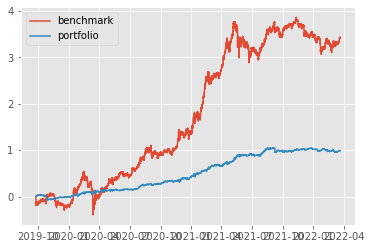

In [ ]:
# data preprocessing

test = pd.read_csv(f'/content/gdrive/MyDrive/MF796/crpyto_data/Bitfinex_ETHUSD_1h.csv',header=0,index_col=0,names=('unix','date','symbol','open','high','low','close','volume1','volume2'))
#test['Date'] = pd.to_datetime(test['date'])
#test = test['2019-02-16':'2022-03-23']
test = test[(test['date']>'2019-02-16 00:00:00')&(test['date']<'2022-03-23 00:00:00')]
print(test.head(1).append(test.tail(1)))
print(test)
print(type(test['date']))
test['date'] = pd.to_datetime(test["date"],errors='coerce',format='%Y-%m-%d %I:%M:%S')
print(test)
test = test[(test['date']>'2019-06-19 00:00:00')&(test['date']<'2022-03-23 00:00:00')]
print(test)